# Analyzing flight data with `dask.dataframe`

In this notebook we do a brief demo of using `dask.dataframe` on the airline flight data from [here](http://stat-computing.org/dataexpo/2009/the-data.html). This contains data on 22 years of all flights inside the USA, including information such as origin and destination, delays, and cancellations. The data has been extracted and decompressed into a folder of csv files, totalling around 11 GB, and 121 million rows.

In [1]:
%%bash
du -hc airline_data/*.csv

121M	airline_data/1987.csv
478M	airline_data/1988.csv
464M	airline_data/1989.csv
486M	airline_data/1990.csv
468M	airline_data/1991.csv
470M	airline_data/1992.csv
468M	airline_data/1993.csv
478M	airline_data/1994.csv
506M	airline_data/1995.csv
509M	airline_data/1996.csv
515M	airline_data/1997.csv
513M	airline_data/1998.csv
527M	airline_data/1999.csv
544M	airline_data/2000.csv
573M	airline_data/2001.csv
506M	airline_data/2002.csv
598M	airline_data/2003.csv
639M	airline_data/2004.csv
640M	airline_data/2005.csv
641M	airline_data/2006.csv
670M	airline_data/2007.csv
657M	airline_data/2008.csv
 11G	total


## Open with dask.dataframe

We can load all the files into a `dask.dataframe` using a clone of the `read_csv` method from pandas. 

Note that dask determines the datatype of each column by reading the first 1000 rows of the first file. If a column has integers for 1000 rows, and then a `NaN`, it will error as the dtype was improperly guessed. As such, we need to pass in some specified datatypes for a few columns. We'll also rename the columns from the original `CamelCase` to `snake_case`, as the `snake_case` is more pythonic.

``dask.dataframe.read_csv`` can take a glob of filenames, we'll only glob the first 3 years for now (the reason will become apparent later).

In [2]:
import dask.dataframe as dd

In [3]:
cols = ['year', 'month', 'day_of_month', 'day_of_week', 'deptime', 'crs_deptime', 'arrtime', 
        'crs_arrtime', 'unique_carrier', 'flight_num', 'tail_num', 'actual_elapsed_time',
        'crs_elapsed_time', 'air_time', 'arrdelay', 'depdelay', 'origin', 'dest', 'distance', 
        'taxi_in', 'taxi_out', 'cancelled', 'cancellation_code', 'diverted', 'carrier_delay',
        'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']

dtypes = {'cancellation_code': object, 'taxi_in': float, 'taxi_out': float, 'cancelled': bool,
          'diverted': bool, 'carrier_delay': float, 'weather_delay': float, 'nas_delay': float,
          'security_delay': float, 'late_aircraft_delay': float, 'tail_num': object,
          'crs_deptime': float, 'crs_arrtime': float, 'flight_num': float, 'crs_elapsed_time': float,
          'distance': float}

df = dd.read_csv('airline_data/198*.csv', header=0, names=cols, dtype=dtypes)

We now have a `dask.dataframe.DataFrame` object. This looks a lot like a pandas `DataFrame`, and has many of the same methods:

In [4]:
df.head()

year  month  day_of_month  day_of_week  deptime  crs_deptime  arrtime  \
0  1987     10            14            3      741          730      912   
1  1987     10            15            4      729          730      903   
2  1987     10            17            6      741          730      918   
3  1987     10            18            7      729          730      847   
4  1987     10            19            1      749          730      922   

   crs_arrtime unique_carrier  flight_num         ...          taxi_in  \
0          849             PS        1451         ...              NaN   
1          849             PS        1451         ...              NaN   
2          849             PS        1451         ...              NaN   
3          849             PS        1451         ...              NaN   
4          849             PS        1451         ...              NaN   

   taxi_out  cancelled  cancellation_code  diverted  carrier_delay  \
0       NaN      False                NaN     False            NaN   
1       NaN      False                NaN     False            NaN   
2       NaN      False                NaN     False            NaN   
3       NaN      False                NaN     False            NaN   
4       NaN      False                NaN     False            NaN   

  weather_delay nas_delay  security_delay  late_aircraft_delay  
0           NaN       NaN             NaN                  NaN  
1           NaN       NaN             NaN                  NaN  
2           NaN       NaN             NaN                  NaN  
3           NaN       NaN             NaN                  NaN  
4           NaN       NaN             NaN                  NaN  

[5 rows x 29 columns]

In [5]:
df.dtypes

year                     int64
month                    int64
day_of_month             int64
day_of_week              int64
deptime                float64
crs_deptime            float64
arrtime                float64
crs_arrtime            float64
unique_carrier          object
flight_num             float64
tail_num                object
actual_elapsed_time    float64
crs_elapsed_time       float64
air_time               float64
arrdelay               float64
depdelay               float64
origin                  object
dest                    object
distance               float64
taxi_in                float64
taxi_out               float64
cancelled                 bool
cancellation_code       object
diverted                  bool
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
dtype: object

The dask `DataFrame` is partitioned into chunks along the index. To see how many partitions, you can use the `npartitions` attribute.

In [6]:
df.npartitions

34

Many of the methods available in pandas are also available in dask. The difference is, expressions don't evaluate immediately, but instead build up a graph of the computation to be executed later. To finally run the computation, you need to call the `compute` method.

Lets just create some expressions for now:

In [7]:
# Maximum departure delay over the 3 years
expr = df.depdelay.max()
expr

In [8]:
# Maximum departure delay for flights leaving 'EWR'
expr = df.depdelay[df.origin == 'EWR'].max()
expr

In [9]:
# Mean departure delay for each airport
expr = df.depdelay.groupby(df.origin).mean()
expr

dd.Series<elemwise-f5bd11af0a2aee1b916066b715a75abd, divisions=(None, None)>

In [10]:
# Top 10 airports by mean departure delay
expr = df.depdelay.groupby(df.origin).mean().nlargest(10)
expr

dd.Series<series-nlargest-n=10--second-d93800cdbed7ede44754b5955132cb5f, divisions=(None, None)>

None of these expressions are actually computed yet - instead they have built up a graph expressing the computation. When the `compute` method is called, this graph will be executed by a scheduler in parallel (using threads by default). Because some operations in pandas release the [Global Interpreter Lock](https://wiki.python.org/moin/GlobalInterpreterLock), we can achieve some level of parallelism. The schedulers also try to minimize memory use, by only loading data as it's needed. This allows us to work on data that is larger than the RAM available on your computer.

## Parsing csvs is slow...

The data is currently stored as csvs, which can be slow to parse. We can profile exactly how slow using the tools available in the [diagnostics](http://dask.pydata.org/en/latest/diagnostics.html) submodule. We'll also register a progress bar, so we can monitor our computations as they run.


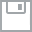
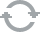
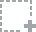
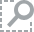
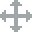
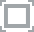
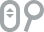
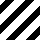
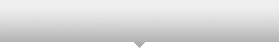
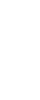
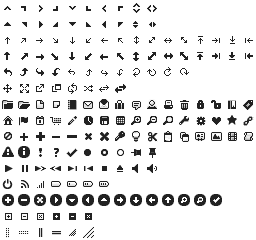
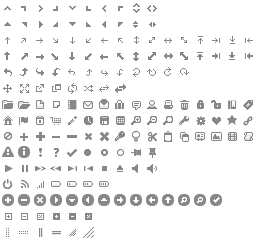
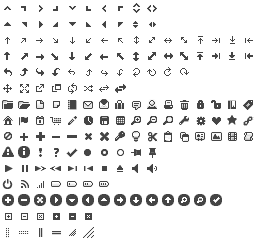
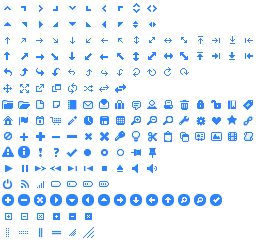
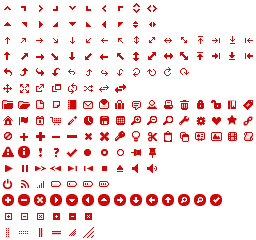
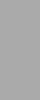
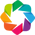
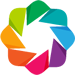

In [11]:
from dask.diagnostics import ProgressBar, Profiler, ResourceProfiler, visualize
import bokeh.plotting as bp
ProgressBar().register()
bp.output_notebook()

Here we'll run the last expression we created above - finding the top 10 airports by mean departure delay from 1987-1989. We'll use both the `Profiler` (for profiling task timings) and the `ResourceProfiler` (for profiling CPU and memory usage).

In [12]:
with Profiler() as prof, ResourceProfiler() as rprof:
    res = expr.compute()

[########################################] | 100% Completed | 35.4s


In [13]:
res

origin
PIR    85.000000
ABI    36.500000
EGE    32.363636
BFI    28.000000
ROP    24.700000
ACV    19.740223
SUN    19.000000
YAP    16.902482
RDD    15.724234
HDN    14.147350
dtype: float64

This took ~35 seconds for only 3 years worth. If we were running on the entire 22 year dataset, this would be far to slow for interactive work. To determine what's causing the slowdown, we can plot the task timings and resource usage together using the `visualize` command.

In [14]:
visualize([prof, rprof])

The top plot shows what task each worker (threads in this case) is executing over time. The tasks are color coded by function, and can be inspected by hovering over the rectangle with your mouse. As can be seen here, much of the time is spent in calls to `_read_csv`, which is a thin wrapper around `pandas.read_csv`. Only a small amount of time is spent on the actual computation (calls to `groupby`, `getitem`, etc...). 

The bottom plot shows CPU and memory usage over time. From this we can see that the calls to `_read_csv` aren't parallelizing well - indicating that `pandas.read_csv` holds the GIL. We're not getting much parallelism here, with spikes over 100% occuring only in the compute heavy portitions (`groupby`, etc...).

These plots combined indicate that the storage format is our limiting factor here. Parsing csvs is slow, and also holds the GIL, so it doesn't parallelize. To improve performance, we'll have to change to another format.

## Repeat with Castra

[Castra](https://github.com/blaze/castra) is a partitioned column store based on the [blosc](http://blosc.org/) compressor. It is designed to play well with `dask.dataframe`, improving load time and reducing IO costs. It is an experimental codebase, and not ready for production use. Here it serves to demonstrate the importance of storage format in computation speed.

I created a castra from the airline data using code found [here](https://gist.github.com/jcrist/b5bfbf3be5ca8cf0c20d). In the process I also added an index along the departure date (converting the `'year'`, `'month'`, and `'day_of_month'` columns into a single `Timestamp`). The `'dest'`, `'origin'`, `'cancellation_code'`, and `'unique_carrier'` columns were also stored as [pandas categoricals](http://matthewrocklin.com/blog/work/2015/06/18/Categoricals/), as they are inherently categorical.

To load the data from the castra into a dask `DataFrame`, we use the `from_castra` method.

In [15]:
df = dd.from_castra('airport.castra/')

We now have a `DataFrame` that holds all 22 years of the airline data. The only difference between it and the dataframe above is how the data will be loaded, but as we shall see below this makes a big difference in performance. 

Here we run the same computation again, except loading the data a castra instead of from csvs. Note that this is for all 22 years, instead of the 3 years we did earlier.

In [16]:
with Profiler() as prof, ResourceProfiler() as rprof:
    top_avg_depdelay = df.depdelay.groupby(df.origin).mean().nlargest(10).compute()

[########################################] | 100% Completed | 47.8s


In [17]:
top_avg_depdelay

origin
FMN    203.666667
CYS    145.000000
OGD    143.666667
BFF    131.000000
PIR     38.100000
BFI     28.000000
ACK     27.383212
CKB     25.625000
SOP     25.241042
ADK     22.731978
dtype: float64

In [18]:
visualize([prof, rprof])

Looking at the profile plot above, we can see a few big differences between it and the one for the csv files. The computation is no longer dominated by the tasks loading the data, and instead is roughly 50-50 loading and computation steps. Further, the CPU load is consistently greater than 100%, averaging around 125%. This shows that we're achieving some level of parallelism throughout. The execution time was also severely reduced - we processed 22 years of data in ~45 seconds. This is roughly 6 times faster than loading from csvs.

## Cancelled flights by day

With the data stored in a more accesible format, it becomes easier to do some interactive exploration of the dataset. Here we'll compute the number of cancelled flights each day over all 22 years. This is composed of two operations:
- Selecting only the flights that are cancelled
- Resampling over this series by day, counting all flights in each bin

In [19]:
cancelled_by_day = df.cancelled[df.cancelled == True].resample('d', how='count').compute()

[########################################] | 100% Completed | 48.6s


In [20]:
fig = bp.figure(x_axis_type='datetime', title='Cancelled flights by day', 
                plot_height=300, plot_width=600)
fig.line(x=cancelled_by_day.index, y=cancelled_by_day.values)
fig.title_text_font_size = '16pt'
fig.xaxis.axis_label = 'Date'
fig.xaxis.axis_label_text_font_size = '12pt'
fig.yaxis.axis_label = 'Cancelled Flights'
fig.yaxis.axis_label_text_font_size = '12pt'
bp.show(fig)

If you zoom in you can see that the huge spike is 9/11/2001.

## Shared sub-expressions

Sometimes you may want to compute several outputs that may share sub-expressions. Instead of calling the `compute` method on each output, you can use the `dask.dataframe.compute` function, which computes multiple results, sharing intermediates. This improves efficiency, as the intermediate computations then only need to be done once.

Here we'll select all flights out of EWR, and then compute the daily and weekly mean departure delays for these flights. By using the `compute` function, we only have to compute the selection of flights from EWR (`from_ewr` variable) once.

In [21]:
from_ewr = df.depdelay[df.origin=='EWR']
by_week = from_ewr.resample('W', how='mean')
by_month = from_ewr.resample('M', how='mean')
by_week, by_month = dd.compute(by_week, by_month)

[########################################] | 100% Completed | 42.4s


In [22]:
fig = bp.figure(x_axis_type='datetime', title='Average flight delay out of EWR', 
                plot_height=300, plot_width=600)
fig.line(x=by_week.index, y=by_week.values, color='blue', alpha=0.3, legend='by week')
fig.line(x=by_month.index, y=by_month.values, color='red', legend='by month')
fig.title_text_font_size = '16pt'
fig.xaxis.axis_label = 'Date'
fig.xaxis.axis_label_text_font_size = '12pt'
fig.yaxis.axis_label = 'Departure Delay (min)'
fig.yaxis.axis_label_text_font_size = '12pt'
bp.show(fig)

## Learning More

This is only a short overview of the features that `dask.dataframe` implements. To learn more:

- See the dask documentation [here](http://dask.pydata.org/en/latest/)
- Try out some examples online using [binder](http://mybinder.org/) [here](http://mybinder.org/repo/blaze/dask-examples)
- Watch the [tutorial from PyData Seattle](https://www.youtube.com/watch?v=ieW3G7ZzRZ0), or one of the [many](https://www.youtube.com/watch?v=1kkFZ4P-XHg) [talks](https://www.youtube.com/watch?v=yDlCNjtZvLw) [given](https://www.youtube.com/watch?v=HLME2WKTJJ8) on dask at various conferences.
- Follow our blog at [blaze.pydata.org](http://blaze.pydata.org/)
